In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from joblib import dump
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Load the processed development dataset
dev_data_path = "/home/harsh/Hackathons/Convolve/data/dev/Dev_data_to_be_shared.csv"
data = pd.read_csv(dev_data_path)

# Split data into features and target
X = data.drop(columns=["bad_flag", "account_number"])  # Exclude target and primary key
y = data["bad_flag"]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using XGBoost's built-in scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 10]
}

# Convert parameter grid to explicit combinations
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to store the best model and score
best_model = None
best_score = 0
best_params = None

# Progress bar for hyperparameter tuning
for params in tqdm(param_combinations, desc="GridSearch Progress"):
    # Create and train the model with the current set of parameters
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        random_state=42,
        **params
    )
    model.fit(X_train, y_train)

    # Predict probabilities on validation set
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)

    # Update the best model if the current one is better
    if auc > best_score:
        best_model = model
        best_score = auc
        best_params = params

# Print the best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best AUC-ROC Score: {best_score}")





GridSearch Progress: 100%|██████████| 128/128 [39:29<00:00, 18.51s/it]

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1.0}
Best AUC-ROC Score: 0.8435897739857194


FileNotFoundError: [Errno 2] No such file or directory: './home/harsh/Hackathons/Convolve/models/xgboost_best_model.pkl'

Validation AUC-ROC: 0.8435897739857194
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     19088
           1       0.05      0.75      0.09       274

    accuracy                           0.78     19362
   macro avg       0.52      0.76      0.48     19362
weighted avg       0.98      0.78      0.86     19362



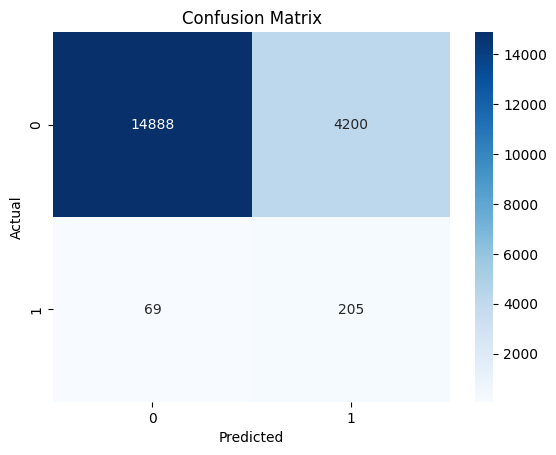

<Figure size 1000x800 with 0 Axes>

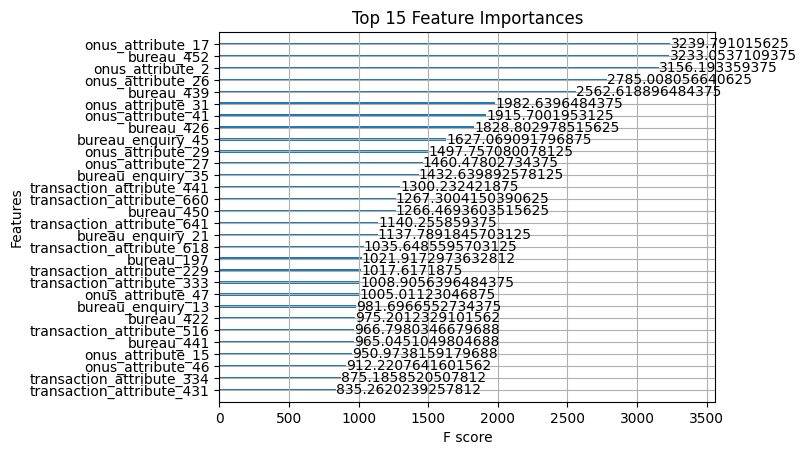

In [4]:
# Evaluate on validation set
y_val_pred_prob = best_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Validation AUC-ROC: {roc_auc}")

# Generate classification report and confusion matrix
y_val_pred = (y_val_pred_prob > 0.5).astype(int)
print(classification_report(y_val, y_val_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, max_num_features=30, importance_type="gain")
plt.title("Top 15 Feature Importances")
plt.show()

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import setup, compare_models, pull, save_model , predict_model

# Load the processed development dataset
dev_data_path = "/home/harsh/Hackathons/Convolve/data/dev"
data = pd.read_csv(dev_data_path)

# Quick overview of the dataset
print("Dataset Overview:")
print(data.info())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Describe dataset for basic stats
stats = data.describe().T
print("Dataset Statistics:")
print(stats)

# PyCaret Setup
# Define target and ignore primary key
clf_setup = setup(
    data=data,
    target="bad_flag",
    ignore_features=["account_number"],  # Primary key column
    session_id=42,  # Ensure reproducibility
    silent=True,
    normalize=True,  # Normalize numerical features
    feature_selection=True,  # Enable feature selection
    fix_imbalance=True,  # Handle class imbalance
    remove_multicollinearity=True,  # Remove correlated features
    multicollinearity_threshold=0.9,  # Threshold for multicollinearity
    use_gpu=True  # Use GPU for faster computation
)

# Compare models and select the best
print("Training models and comparing performance...")
best_model = compare_models()

# Retrieve and display all model performance metrics
model_performance = pull()
print("Model Performance Metrics:")
print(model_performance)

# Save the best model
save_model(best_model, "/home/harsh/Hackathons/Convolve/models")
print("Best model saved!")

# Feature Importance
from pycaret.utils import check_metric

# Evaluate the best model on unseen data (optional)
print("Evaluating the best model...")
predictions = predict_model(best_model)
print(predictions.head())

# Feature importance plot
plt.figure(figsize=(10, 8))
feature_importance = best_model.feature_importances_  # Best model feature importance
sns.barplot(x=feature_importance, y=data.drop(columns=["bad_flag", "account_number"]).columns)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Save predictions for validation
predictions["account_number"] = data["account_number"]  # Add back primary key
predictions.to_csv("../outputs/predictions/validation_predictions.csv", index=False)
print("Predictions saved!")


RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=7, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')